In [191]:
import fastbook
from fastbook import *
from fastai.vision.all import *
from fastai.vision.widgets import *
import timm
from duckduckgo_search import ddg_images
from time import sleep
import os
import gradio

In [131]:
def search_images(term, max_images=100):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [132]:
searches = 'moose', 'deer', 'elk'
path = Path('trail_cam')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls = search_images(f'{o} trail cam photo'))
    sleep(10)
    download_images(dest, urls = search_images(f'{o} trail cam photo day'))
    sleep(10)
    download_images(dest, urls = search_images(f'{o} trail cam photo night'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'moose trail cam photo'
Searching for 'moose trail cam photo day'
Searching for 'moose trail cam photo night'
Searching for 'deer trail cam photo'
Searching for 'deer trail cam photo day'
Searching for 'deer trail cam photo night'
Searching for 'elk trail cam photo'
Searching for 'elk trail cam photo day'
Searching for 'elk trail cam photo night'


In [133]:
fns = get_image_files(path)
len(fns)

877

In [134]:
failed = verify_images(fns)
failed.map(Path.unlink)
fns = get_image_files(path)
len(failed), len(fns)

(12, 865)

In [164]:
os.getcwd()
for i, filename in enumerate(os.listdir(path/'deer')):
   os.rename("trail_cam/deer/" + filename, "trail_cam/deer/deer_" + str(i) + ".jpg")
for i, filename in enumerate(os.listdir(path/'moose')):
   os.rename("trail_cam/moose/" + filename, "trail_cam/moose/moose_" + str(i) + ".jpg")
for i, filename in enumerate(os.listdir(path/'elk')):
   os.rename("trail_cam/elk/" + filename, "trail_cam/elk/elk_" + str(i) + ".jpg")

In [165]:
dls = ImageDataLoaders.from_name_func('.',
    get_image_files(path), valid_pct=0.2, seed=42,
    label_func=RegexLabeller(pat = r'^([^/]+)_\d+'),
    item_tfms=Resize(224))

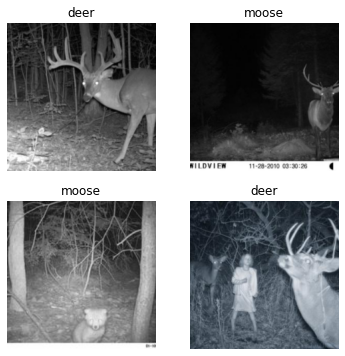

In [166]:
dls.valid.show_batch(max_n=4)

In [167]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.002779,1.369467,0.586207,00:07


epoch,train_loss,valid_loss,error_rate,time
0,1.426437,1.002604,0.425287,00:03
1,1.082575,0.859882,0.413793,00:03
2,0.907559,0.716293,0.333333,00:03
3,0.748531,0.688598,0.252874,00:03
4,0.647351,0.693779,0.264368,00:03


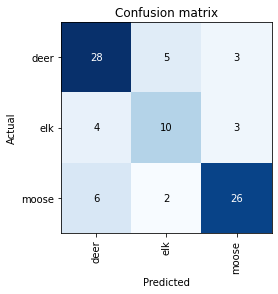

In [168]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

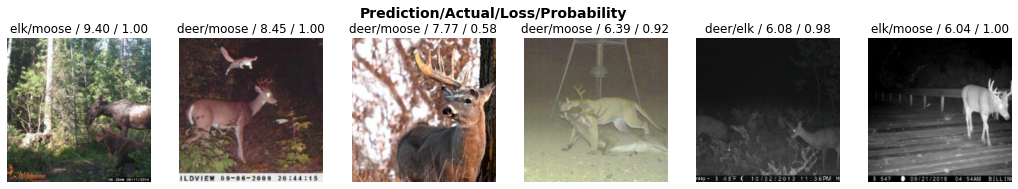

In [151]:
interp.plot_top_losses(6, nrows=1)

In [169]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [170]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
    
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
    
dls = ImageDataLoaders.from_name_func('.',
    get_image_files(path), valid_pct=0.2, seed=42,
    label_func=RegexLabeller(pat = r'^([^/]+)_\d+'),
    item_tfms=Resize(224))

In [171]:
learn = vision_learner(dls, 'convnext_tiny_in22k', metrics=error_rate).to_fp16()
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.692869,3.532001,0.581395,00:03


epoch,train_loss,valid_loss,error_rate,time
0,0.983810,1.380556,0.313953,00:03
1,0.885328,0.899624,0.232558,00:03
2,0.792400,0.785097,0.255814,00:03
3,0.720126,0.789632,0.197674,00:03
4,0.623536,0.744941,0.186047,00:03
5,0.556991,0.737408,0.209302,00:03
6,0.512330,0.754599,0.197674,00:03
7,0.464188,0.772003,0.197674,00:03
8,0.431808,0.771565,0.197674,00:03
9,0.404420,0.780129,0.197674,00:03


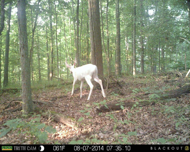

In [184]:
from fastdownload import download_url
urls = search_images_ddg('trail cam deer')
urls[0]
download_url(urls[2], 'deer.jpg')

im = Image.open('deer.jpg')
im.to_thumb(190,190)

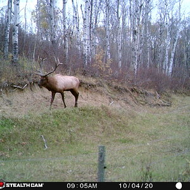

In [174]:
urls = search_images_ddg('trail cam elk')
urls[0]
download_url(urls[0], 'elk.jpg')

im = Image.open('elk.jpg')
im.to_thumb(190,190)

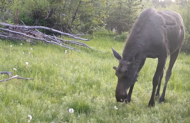

In [175]:
urls = search_images_ddg('trail cam moose')
urls[1]
download_url(urls[1], 'moose.jpg')

im = Image.open('moose.jpg')
im.to_thumb(190,190)

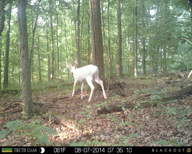

In [185]:
im = PILImage.create("deer.jpg")
im.thumbnail((192, 192))
im

In [186]:
learn.predict(im)

('deer', TensorBase(0), TensorBase([0.6719, 0.0927, 0.2354]))

# Pickel and export model to be uploaded to gradio

In [187]:
learn.export('model.pkl')

In [192]:
from fastai.vision.all import *
import gradio as gr

learn = load_learner('model.pkl')
categories = learn.dls.vocab

def classify_image(img):
    img = PILImage.create(img)
    pred, idx, probs = learn.predict(img)
    return dict(zip(categories, map(float,probs)))

In [193]:
image = gr.inputs.Image(shape=(192,192))
label = gr.outputs.Label()
examples = ['deer.jpg', 'elk.jpg', 'moose.jpg']

intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(inline=False, share=True)

/usr/local/lib/python3.9/dist-packages/gradio/inputs.py:256: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.9/dist-packages/gradio/outputs.py:196: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://27270.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x7f8110cc3040>,
 'http://127.0.0.1:7860/',
 'https://27270.gradio.app')